In [1]:
import librosa
import librosa.display
import obspy
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import tsfel
import pandas as pd
import csv
import wave
import math

In [2]:
# getting wav_files_paths
wav_files_paths = []

# open the CSV file in read mode
with open('wav_files_paths.csv', 'r') as file:
    reader = csv.reader(file)
    # Iterate through the rows in the CSV file
    for row in reader:
        # Append each row to the list
        wav_files_paths.append(row[0])

print(wav_files_paths[0])
print(wav_files_paths[30])

./data/wav/OS_7_05_2019_08_24_00_.wav
./data/wav/rpi-port-townsend_2019_11_14_14_28_00.wav


In [3]:
# converting annotations.tsv into df
annotations_file_path = './data/annotations.tsv'
df = pd.read_csv(annotations_file_path, sep='\t')
df.head()

,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round1,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",1960-10-28,60012
1,podcast_round1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",1960-10-28,60012
2,podcast_round1,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",1960-10-28,60012
3,podcast_round1,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",1960-10-28,60012
4,podcast_round1,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012


In [4]:
# find number of unique filenames in annotations.tsv
num_unique_filenames = df['wav_filename'].nunique()
print(num_unique_filenames)

2863


In [5]:
# find number of unique filenames in wav directory
!find ./data/wav -type f | wc -l

# since num wav files > num filenames in annotations.tsv, I will iterate through the
# ones in annotations.tsv

2976


In [6]:
# Remove rows from df where the filename doesn't correspond to an actual wav file
indices_to_drop = []
file_path = "data/wav/"
for index, row in df.iterrows():
    filename = df.loc[index, 'wav_filename']
    if not os.path.isfile(file_path + filename):
        indices_to_drop.append(index)

print(indices_to_drop)
df = df.drop(indices_to_drop)

[]


In [7]:
# REMOVE DATA FROM ROUNDS 11 AND 12, MAKE SEPARATE DFS FOR THEM
round_11_df = df[df['dataset'].str.contains('round11')]
round_12_df = df[df['dataset'].str.contains('round12')]
df = df[~df['dataset'].str.contains('round11')]
df = df[~df['dataset'].str.contains('round12')]

In [8]:
print(round_11_df.shape)
print(round_12_df.shape)

(118, 7)
(54, 7)


In [9]:
# create orca_call_df which has cols wav_filename, start_time_s, end_time_s

# create new df with cols wav_filename, start_time_s as cols
orca_call_df = df[['wav_filename', 'start_time_s']]

# add end_time_s col by adding duration_s to start_time_s
orca_call_df['end_time_s'] = df['start_time_s'] + df['duration_s']

orca_call_df

/tmp/ipykernel_1110365/2355072858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orca_call_df['end_time_s'] = df['start_time_s'] + df['duration_s']


,wav_filename,start_time_s,end_time_s
0,60012.wav,34.126000,37.044000
1,60012.wav,36.816000,39.404000
2,60012.wav,42.550000,44.605000
3,60012.wav,44.606000,47.016000
4,60012.wav,46.636000,50.061000
...,...,...,...
5360,rpi-bush-point_2020_09_27_23_20_00.wav,53.900000,56.350000
5361,rpi-bush-point_2020_09_27_23_20_00.wav,56.350000,58.800000
5362,rpi-bush-point_2020_09_27_23_20_00.wav,13.658286,15.158286
5363,rpi-bush-point_2020_09_27_23_20_00.wav,34.681333,36.181333


In [10]:
# REMOVE DATA WHERE OVERLAPPING WHALE CALLS IN SAME AUDIO FILES
# functions to help removes all rows from df that have given filename
def remove_filenames(df, filenames_list):
  for filename in filenames_list:
    df = remove_filename(df, filename)
  return df

def remove_filename(df, filename):
  df = df.reset_index(drop=True)
  df = df[df['wav_filename'] != filename]
  return df

def find_rows_to_be_deleted(df):
    to_drop_filename = []
    for i in range(len(df) - 1):
        if (df.loc[i, 'wav_filename'] == df.loc[i + 1, 'wav_filename'] and 
            df.loc[i, 'end_time_s'] > df.loc[i + 1, 'start_time_s']):
          to_drop_filename.append(df.loc[i, 'wav_filename'])
    return to_drop_filename

In [11]:
to_drop_filename = find_rows_to_be_deleted(orca_call_df)
orca_call_df = remove_filenames(orca_call_df, to_drop_filename)
orca_call_df

,wav_filename,start_time_s,end_time_s
0,92303001.wav,0.000000,1.059000
1,92303002.wav,0.000000,1.107000
2,92303003.wav,0.000000,1.306000
3,92303004.wav,0.000000,1.466000
4,92303005.wav,0.000000,2.026000
...,...,...,...
2820,rpi-bush-point_2020_09_27_23_30_00.wav,24.500000,26.950000
2821,rpi-bush-point_2020_09_27_23_30_00.wav,31.146750,32.826524
2822,rpi-bush-point_2020_09_27_23_30_00.wav,49.502321,51.450000
2823,rpi-bush-point_2020_09_27_23_30_00.wav,52.593964,54.093964


In [12]:
# REMOVE DATA WHERE START_TIME_S = END_TIME_S = 0
orca_call_df = orca_call_df[~((orca_call_df['start_time_s'] == 0) & (orca_call_df['end_time_s'] == 0))]
print(orca_call_df.shape)

(2416, 3)


In [13]:
# REMOVE DATA WHERE END_TIME_S > LENGTH OF AUDIO FILE
filenames_to_be_removed = []
for index, row in orca_call_df.iterrows():
    filename = row['wav_filename']
    filepath = 'data/wav/' + filename
    if not os.path.isfile(filepath):
        print(f"File not found: {filepath}")
        continue
    start_time = row['start_time_s']  # Keep in seconds
    end_time = row['end_time_s']  # Keep in seconds
    audio, sr = librosa.load(filepath)
    audio_length = len(audio) / sr
    if end_time > audio_length:
        filenames_to_be_removed.append(filename)
        
print(len(filenames_to_be_removed))

59


In [14]:
orca_call_df = orca_call_df[~orca_call_df['wav_filename'].isin(filenames_to_be_removed)]
orca_call_df.shape

(2347, 3)

In [15]:
# CREATING NOISE_DF
# create wav_filenames_len_dict which contains wav_filename and total_length
directory = './data/wav'

# initialize lists to store filenames and lengths
filenames = []
lengths = []

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        
        # load wav file
        y, sr = librosa.load(file_path, sr=None)
        # calculate length in seconds
        length = librosa.get_duration(y=y, sr=sr)
        
        # append the filename and length to the lists
        filenames.append(filename)
        lengths.append(length)

# creating dict where keys are wav_filenames and values are total_lengths
wav_filenames_len_dict = dict(zip(filenames, lengths))

In [16]:
print(len(wav_filenames_len_dict))

2975


In [17]:
noise_df = pd.DataFrame()

In [18]:
for wav_filename in wav_filenames_len_dict:
    if wav_filename in orca_call_df['wav_filename'].values:
        # create df with only rows of orca_call_df
        times_df = orca_call_df[orca_call_df['wav_filename'] == wav_filename][['start_time_s', 'end_time_s']]
        times_df = times_df.sort_values(by='start_time_s')
        times = []
        # fills times list with times in times_df
        for index, row in times_df.iterrows():
          times.append(row['start_time_s'])
          times.append(row['end_time_s'])
        # add 0 or length of audio file if necessary
        noise_start_index = 1
        # adding 0 if necessary:
        if times[0] != 0: # if whale call doesn't start at 0s
            times.insert(0, 0)
            noise_start_index = 0
        # adding length of audio file if necessary
        if times[len(times)-1] != wav_filenames_len_dict[wav_filename]: # if whale call doesn't end when the wav file ends
            length = wav_filenames_len_dict[wav_filename]
            times.insert(len(times), length)
        # populate noise_df
        if noise_start_index == 0:
            while len(times) > 1: # times is not empty
                new_row = {'wav_filename': wav_filename, 'start_time_s': times[0], 'end_time_s': times[1]}
                times.pop(0)
                times.pop(0)
                noise_df = pd.concat([noise_df, pd.DataFrame([new_row])], ignore_index=True)
        else: # noise_start_index = 1 eg: [0, 3.6, 4.0, 6.0, 7.7, 10]
            times.pop(0)
            while len(times) > 1: # times is not empty
                new_row = {'wav_filename': wav_filename, 'start_time_s': times[0], 'end_time_s': times[1]}
                times.pop(0)
                times.pop(0)
                noise_df = pd.concat([noise_df, pd.DataFrame([new_row])], ignore_index=True)
    elif wav_filename in round_11_df['wav_filename'].values or wav_filename in round_12_df['wav_filename'].values:
            time_duration = wav_filenames_len_dict[wav_filename]
            new_row = {'wav_filename': wav_filename, 'start_time_s': 0, 'end_time_s': time_duration}
            noise_df = pd.concat([noise_df, pd.DataFrame([new_row])], ignore_index=True)
        
noise_df

,wav_filename,start_time_s,end_time_s
0,1562337136_0010.wav,0.000000,14.451172
1,1562337136_0010.wav,16.221680,47.755859
2,1562337136_0010.wav,49.765625,56.895508
3,1562337136_0010.wav,59.240234,61.250000
4,1562337136_0012.wav,0.000000,31.508298
...,...,...,...
2383,rpi-port-townsend_2020_10_08_02_20_00.wav,0.000000,60.010667
2384,rpi-port-townsend_2020_10_08_02_25_00.wav,0.000000,60.010667
2385,rpi-port-townsend_2020_10_08_02_29_00.wav,0.000000,59.989333
2386,rpi-port-townsend_2020_10_08_02_35_00.wav,0.000000,59.989333


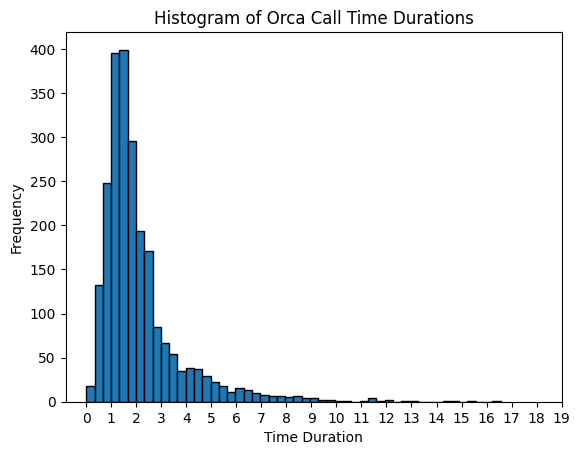

In [19]:
# SEEING HISTOGRAM FOR TIME DURATIONS OF ORCA CALLS
orca_durations = pd.DataFrame()
orca_durations['durations'] = orca_call_df['end_time_s'] - orca_call_df['start_time_s']
orca_durations_list = orca_durations['durations'].tolist()

# Create the histogram
plt.hist(orca_durations_list, bins=50, edgecolor='black')

# Add title and labels
plt.title('Histogram of Orca Call Time Durations')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

plt.xticks(range(0, 20, 1))

# Show the plot
plt.show()

# Most orca calls have a time duration of 1s. 

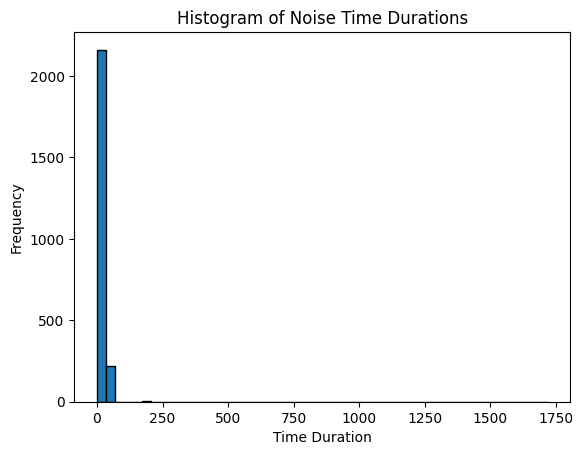

In [20]:
# SEEING HISTOGRAM FOR TIME DURATIONS OF ORCA CALLS
noise_durations = pd.DataFrame()
noise_durations['durations'] = noise_df['end_time_s'] - noise_df['start_time_s']
noise_durations_list = noise_durations['durations'].tolist()

# Create the histogram
plt.hist(noise_durations_list, bins=50, edgecolor='black')

# Add title and labels
plt.title('Histogram of Noise Time Durations')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

# Show the plot
plt.show()


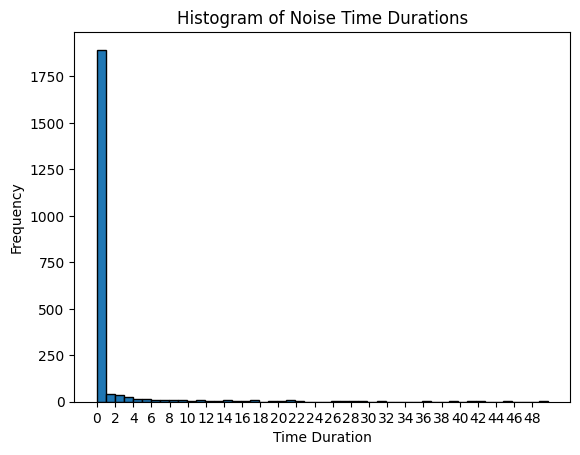

In [21]:
# Still unclear, so removing all values from list higher than 50
noise_durations_list = [value for value in noise_durations_list if value <= 50]

# Create the histogram
plt.hist(noise_durations_list, bins=50, edgecolor='black')

plt.xticks(range(0, 50, 2))

# Add title and labels
plt.title('Histogram of Noise Time Durations')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Most noise calls have a time duration of 1s. 

In [22]:
# Remove rows from df where duration < 1s. If duration > 1s, break into 1s chunks
# and add to temp_df (merge with df later)

def break_into_segments_or_remove(df):
    indices_to_be_removed = []

    # create temp_df to store segments
    cols = df.columns.tolist()
    temp_df = pd.DataFrame(columns=cols)

    # looping through rows
    for index, row in df.iterrows():
        time_duration = row['end_time_s'] - row['start_time_s']
        if time_duration < 1:
            indices_to_be_removed.append(index)
        elif time_duration > 1: # time_duration >= 1
            time_duration = math.floor(time_duration)
            start_time = row['start_time_s']
            while start_time <= row['end_time_s'] - 1:
                wav_filename = row['wav_filename']
                end_time = start_time + 1
                new_row = {'wav_filename': wav_filename, 'start_time_s': start_time, 
                        'end_time_s': end_time}
                temp_df = pd.concat([temp_df, pd.DataFrame([new_row])], ignore_index=True) 
                start_time += 1
                indices_to_be_removed.append(index)
    
    if indices_to_be_removed: 
        df = df.drop(index=indices_to_be_removed)

    df = pd.concat([df, temp_df], ignore_index=True)
    return df

In [23]:
orca_call_df = break_into_segments_or_remove(orca_call_df)
noise_df = break_into_segments_or_remove(noise_df)

/tmp/ipykernel_1110365/945324999.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([temp_df, pd.DataFrame([new_row])], ignore_index=True)
/tmp/ipykernel_1110365/945324999.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([temp_df, pd.DataFrame([new_row])], ignore_index=True)


In [24]:
print(orca_call_df.shape)
print(noise_df.shape)

(3887, 3)
(17934, 3)


In [25]:
# saving clean orca_call_df to csv file
csv_file_path = './data/orca_data.csv'
orca_call_df.to_csv(csv_file_path, index=False)

# saving clean noise_df to csv file
csv_file_path = './data/noise_data.csv'
noise_df.to_csv(csv_file_path, index=False)